In [1]:
import nibabel as nib
import numpy as np
import os
import glob
import sys
import SimpleITK as sitk
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ipynb.fs.full.io_utils import search_file_in_folder_list

In [2]:
def compute_dice(seg1, seg2, label=1.0):
    # flatten the segmentations
    seg1 = seg1.flatten()
    seg2 = seg2.flatten()

    if len(seg1) != len(seg2):
        raise InputError('The two segmentations have different dimensions - not comparable!')

    yt = np.asarray(seg1 == label, np.float32)
    yp = np.asarray(seg2 == label, np.float32)
    
    intersection = np.multiply(yt, yp)
    union = np.asarray(yt + yp > 0, np.float32)
    dice = 2 * np.sum(intersection) / (np.sum(yt) + np.sum(yp) + 1e-10)
    
    return dice

In [3]:
def load_nifty_volume_as_4d_array(filename):
    img_obj = sitk.ReadImage(filename)
    data_array = sitk.GetArrayFromImage(img_obj)
    spacing = img_obj.GetSpacing()
    direction = img_obj.GetDirection()
    shape = data_array.shape
    if(len(shape) == 4):
        data_array = np.moveaxis(data_array, 0, -1) 
    elif(len(shape) == 3):
        data_array = np.expand_dims(data_array, axis = -1)
    else:
        raise ValueError("unsupported image dim: {0:}".format(len(shape)))
    output = {}
    output['data_array'] = data_array
    output['spacing']    = (spacing[2], spacing[1], spacing[0])
    output['direction']  = direction
    return output

In [4]:
def read_nifti(nifti_file):
#     img_nii = nib.load(nifti_file)
#     img = img_nii.get_fdata()
    
    img_dict = load_nifty_volume_as_4d_array(nifti_file)
    img = img_dict['data_array']
    
    # if two channels, get the foreground one
    if img.shape[3] > 1:
        img = img[..., 1]
        
    return img

In [5]:
# set parameters:
# net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
#                 "2020-08-05_17-47-42_CustomUNet25_inplane_Resize_outplaneCrop_larger_filters/inf_on_training_valid_key_metric=0.8792"]
# net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
#                 "2020-08-05_17-47-42_CustomUNet25_inplane_Resize_outplaneCrop_larger_filters/inf_on_validation_valid_key_metric=0.8792"]
# net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
#                 "2020-09-03_19-31-47_CustomUNet25_MultiScaleDice_BoundingBoxCropping/inf_on_valid_valid_key_metric=0.894_gtcrop"]
net_out_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/FBS_Monai/basic_unet_monai/tests_3D_unet/" +
                "2020-09-03_16-00-08_CustomUNet25_MultiScaleDice_lessFilters_dropout0.5/inf_on_train_valid_key_metric=0.7725"]
is_validation_set = False

# list folders to search for the data
data_root = ["/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupA", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB1",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset/GroupB2", 
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupC",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupD",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupE",
             "/mnt/data/mranzini/Desktop/GIFT-Surg/Data/NeuroImage_dataset_extension/GroupF"]

# list of subject IDs to search for data
list_root = "/mnt/data/mranzini/Desktop/GIFT-Surg/Retraining_with_expanded_dataset/config/file_names"
if not is_validation_set:
    training_list = [os.path.join(list_root, "list_train_files.txt")]
else:
    training_list = [os.path.join(list_root, "list_validation_h_files.txt"),
                    os.path.join(list_root, "list_validation_p_files.txt")]

full_list = {"subj_id": [], "Dice": [], "Group": []}
for scan_list in training_list:
    with open(scan_list) as f:
        for line in f:
            subject = line.rstrip()
            print(subject)
            image_basename = "{}{}.nii.gz".format(subject, '_Image')
            image_filename = search_file_in_folder_list(data_root, image_basename)
            label_basename = "{}{}.nii.gz".format(subject, '_Label')
            label_filename = search_file_in_folder_list(data_root, label_basename)
            output_basename = os.path.join("{}_Image".format(subject), "{}_Image_seg.nii.gz".format(subject))
            output_filename = search_file_in_folder_list(net_out_root, output_basename)
            get_group = image_filename[image_filename.find("Group") + 5]
            if get_group == "B":
                get_group = image_filename[image_filename.find("Group") + 5] + \
                    image_filename[image_filename.find("Group") + 6]
                
            if os.path.isfile(image_filename) and os.path.isfile(label_filename) and os.path.isfile(output_filename):
                # compute Dice between gt and seg
                label = np.squeeze(read_nifti(label_filename))
                output = np.squeeze(read_nifti(output_filename))
                output_bin = output > 0.5
                full_list['subj_id'].append(subject)
                full_list['Dice'].append(compute_dice(label, output_bin))
                full_list['Group'].append(get_group)
            else:
                raise IOError('Expected files not found for subject {}'.format(subject))


a01_02
a01_03
a01_04
a03_02
a03_03
a03_04
a05_06
a05_07
a05_09
a07_03
a07_04
a07_05
a08_01
a08_02
a08_03
a09_03
a09_04
a09_05
a10_05
a10_06
a10_07
a11_04
a11_05
a11_06
a12_03
a12_04
a12_05
a13_08
a13_09
a13_10
a14_03
a14_04
a14_05
a16_07
a16_08
a16_09
a18_07
a18_08
a18_09
a19_03
a19_05
a19_06
a20_23
a20_24
a20_25
a21_06
a21_07
a21_08
a22_02
a22_03
a22_04
a25_03
a25_04
a25_07
a27_15
a27_19
a27_23
a28_16
a28_17
a28_18
b12_10
b12_20
b12_40
b13_05
b13_06
b13_07
b15_05
b15_13
b15_14
b16_07
b16_20
b16_21
b19_04
b19_12
b19_26
bch01_04
bch01_05
bch01_06
17_01_14
17_01_18
17_01_19
17_02_10
17_02_12
17_02_22
17_04_09
17_04_20
17_04_23
17_07_11
17_07_20
17_07_21
17_08_05
17_08_12
17_08_13
17_12_07
17_12_08
17_12_09
17_13_07
17_13_08
17_13_09
17_22_06
17_22_07
17_22_08
17_24_07
17_24_08
17_24_09
17_30_18
17_30_19
17_30_20
17_40_09
17_40_10
17_40_11
17_41_06
17_41_07
17_41_08
C03_01
C03_02
C03_03
C03_04
C03_05
C03_06
C04_01
C04_02
C04_03
C04_04
C04_05
C04_06
C04_07
C05_01
C05_02
C05_03
C05_04
C05_0

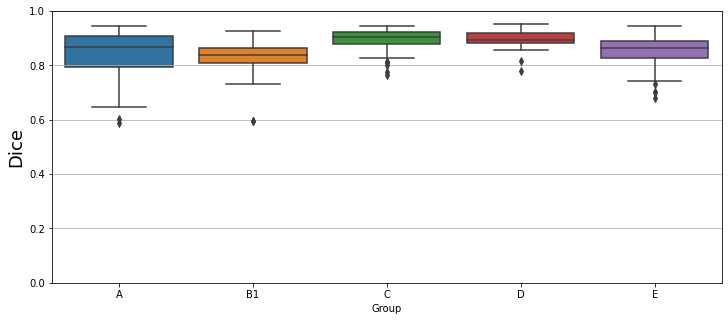

In [6]:
pd1 = pd.DataFrame(data=full_list)

fig = plt.figure(figsize=(12, 5))
b1 = sns.boxplot(x='Group', y='Dice', data=pd1)
b1.set_ylabel('Dice', fontsize=18)
b1.set_ylim([0, 1])
plt.grid(b=True,axis='y')

In [7]:
full_list["Dice"] = np.asarray(full_list["Dice"])
idx = np.squeeze(np.argwhere(full_list["Dice"] < 0.75), axis=-1)
print([full_list['subj_id'][i] for i in idx])
print([full_list['Dice'][i] for i in idx])

['a08_03', 'a09_05', 'a13_09', 'a25_03', 'a25_04', 'a25_07', 'a27_23', 'a28_16', 'b15_14', 'b16_07', 'b16_20', 'b19_26', '17_04_23', '17_07_20', '17_08_13', 'E01_05', 'E03_07', 'E05_01', 'E12_09', 'E18_02']
[0.5882022373250433, 0.7259689997359758, 0.6036168452225413, 0.6472743521000865, 0.7016862291287788, 0.7395599733317126, 0.7167453370875677, 0.7120171437991079, 0.6647390624259343, 0.7290932899846465, 0.6685029289676818, 0.7050174376921479, 0.5959470591465752, 0.5950418524101196, 0.7325558410753105, 0.7424748085449403, 0.6809233354030448, 0.7012989523330878, 0.701535786728483, 0.7316987329892047]


In [8]:
print(np.mean(full_list["Dice"]))

0.8635806877292376
